### Importing Data
Movie data was obtained from Kaggle's TMDB dataset (https://www.kaggle.com/tmdb/tmdb-movie-metadata). The data was cleaned with the `cleaned_data.py` script. The `import_clean_csv` method from the `import_data.py` module is used to import the cleaned TMDB data

In [1]:
import os
import importlib.util
import pandas as pd
import numpy as np
import sys
from scipy import stats
from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm_pandas
tqdm().pandas()

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [6]:
%load_ext autoreload
%autoreload 2

current_file_path = os.path.abspath(os.path.join("__file__" ,"../.."))
tools_path = os.path.abspath(os.path.join(current_file_path, 'src', 'tools'))
sys.path.append(os.path.abspath(os.path.join(tools_path)))
import thinkstats2, thinkplot
from data_vis import get_plotly
import eda_tools as eda

import_data_path = os.path.join(current_file_path,'src','data')

spec = importlib.util.spec_from_file_location("import_clean_csv", os.path.join(import_data_path,"import_clean_data.py"))
import_data = importlib.util.module_from_spec(spec)
spec.loader.exec_module(import_data)

print(current_file_path)
data = import_data.import_clean_csv(current_file_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\Users\ill will\Desktop\Code\springboard\Capstone_1


### Importing Packages for Visualizations

In [4]:
#Following Python packages are necessary for data visualiations below

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import cufflinks as cf

init_notebook_mode(connected=True)
cf.go_offline()

# Read in csv Files

In [13]:
# create dataframes from cleaned data
movies = data['tmdb_movie_main'].set_index(['movie_id', 'title'])
movies['release_date'] = pd.to_datetime(movies['release_date'])

movies['net'] = movies.revenue - movies.budget
movies['net_pct'] = movies.revenue.divide(movies.budget) - 1

In [10]:
crew_dict = {}
for job in ['Director', 'Writer', 'Producer']:
    crew_dict[job] = pd.read_csv(job + '_credits.csv')

In [12]:
crew_dict['Director'].tail()

movie_id                       title                name  unknown  male  \
4331      1494  Curse of the Golden Flower         Zhang Yimou        0     1   
4332     76758          The Flowers of War         Zhang Yimou        0     1   
4333    173224          Along the Roadside       Zoran Lisinac        1     0   
4334     12245          The Oxford Murders  Álex de la Iglesia        0     1   
4335       321              Mambo Italiano    Émile Gaudreault        0     1   

      female  credits  net_to_date  
4331       0        2    227258377  
4332       0        4    247473752  
4333       0        0            0  
4334       0        0            0  
4335       0        0            0

In [30]:
crew_dfs = {}
for k,v in tqdm(crew_dict.items()):
    df = pd.merge(movies.reset_index(),v , on=['movie_id','title']).sort_values('name')
    crew_dfs[k] = eda.split_release_date(df)

crew_dfs['Director'].head(2)

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

movie_id        title    budget original_language  \
3243     44718      Get Low   7000000                en   
2728     21612  The Funeral  12500000                en   

                                               overview  popularity  \
3243  A movie spun out of equal parts folk tale, fab...    6.557643   
2728  The story concerns the funeral of one of three...    2.950618   

     release_date   revenue  runtime    status      ...      vote_count  \
3243   2010-01-22  10828305      103  Released      ...             100   
2728   1996-01-26   1227324       99  Released      ...              31   

           net   net_pct             name  credits gender  net_to_date  \
3243   3828305  0.546901  Aaron Schneider        0      2            0   
2728 -11272676 -0.901814     Abel Ferrara        0      2            0   

      release_day  release_month  release_year  
3243           22              1          2010  
2728           26              1          1996  

[2 rows x 22 columns]

Director


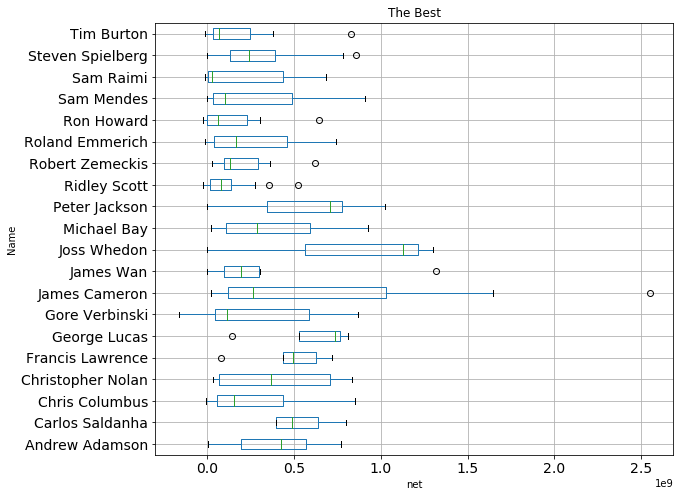

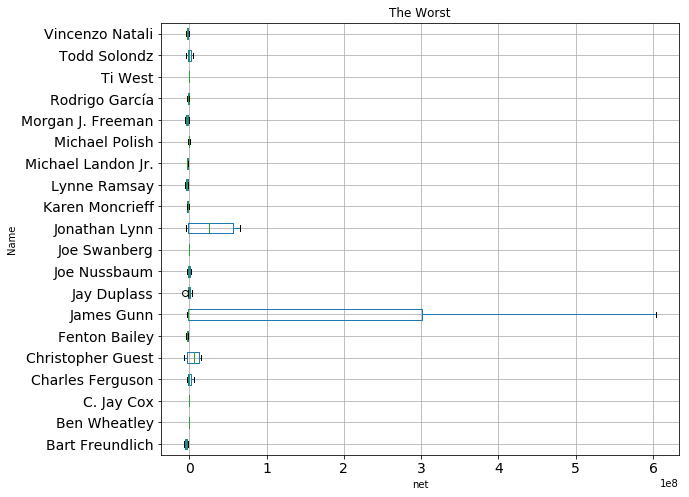

Writer


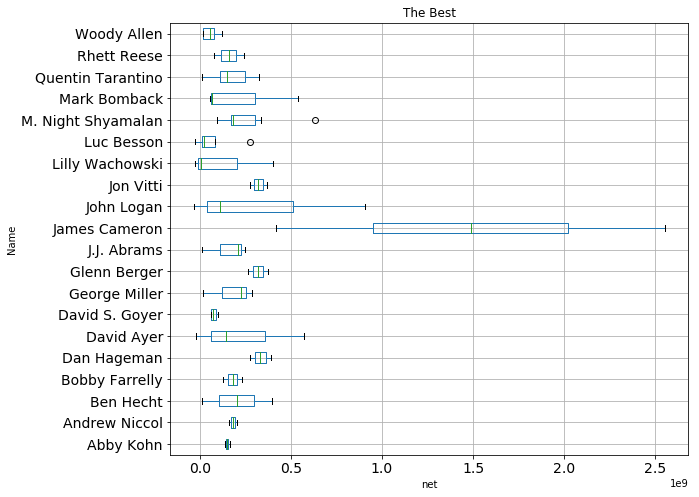

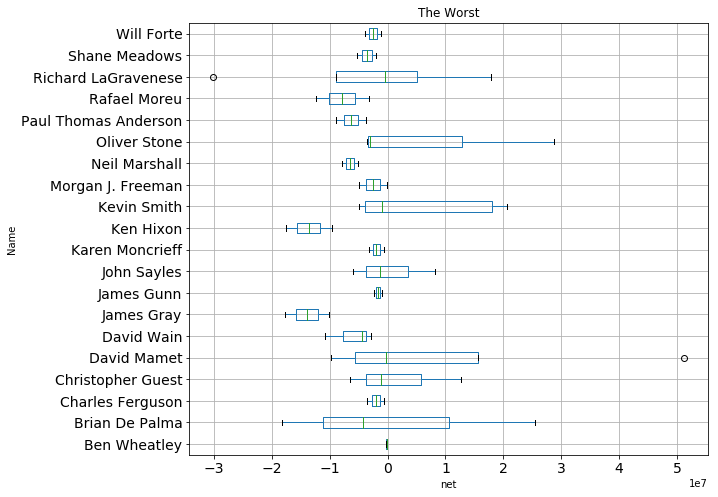

Executive_Producer


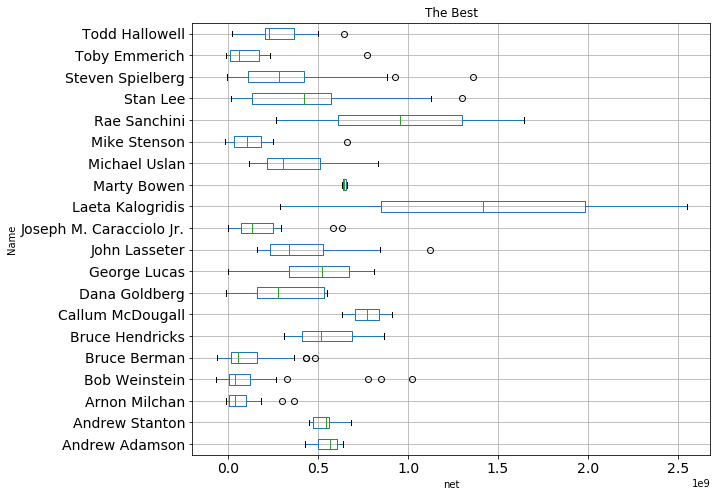

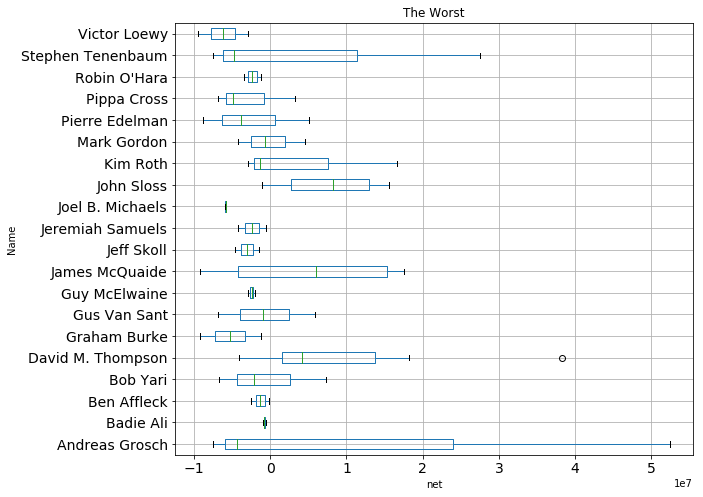

In [26]:
best_worst_crew = {}

for k,v in crew_dfs.items():
    print(k)
    best_worst_crew[k] = eda.get_best_worst_personnel(v,('net','sum'))

In [27]:
for k,v in best_worst_crew.items():    
    data = []
    for c in v[0]:
        crew_history = crew_dfs[k][crew_dfs[k]['name'] == c].sort_values(by='release_date')
        trace = go.Scatter(x=crew_history['release_date'],y=crew_history['net'],text=crew_history['title'], name=c)
        data.append(trace)

    layout=go.Layout(title="Top Grossing " + k)    
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [28]:
for k,v in best_worst_crew.items():    
    data = []
    for c in v[1]:
        crew_history = crew_dfs[k][crew_dfs[k]['name'] == c].sort_values(by='release_date')
        trace = go.Scatter(x=crew_history['release_date'],y=crew_history['net'],text=crew_history['title'], name=c)
        data.append(trace)

    layout=go.Layout(title="Lowest Grossing " + k)    
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

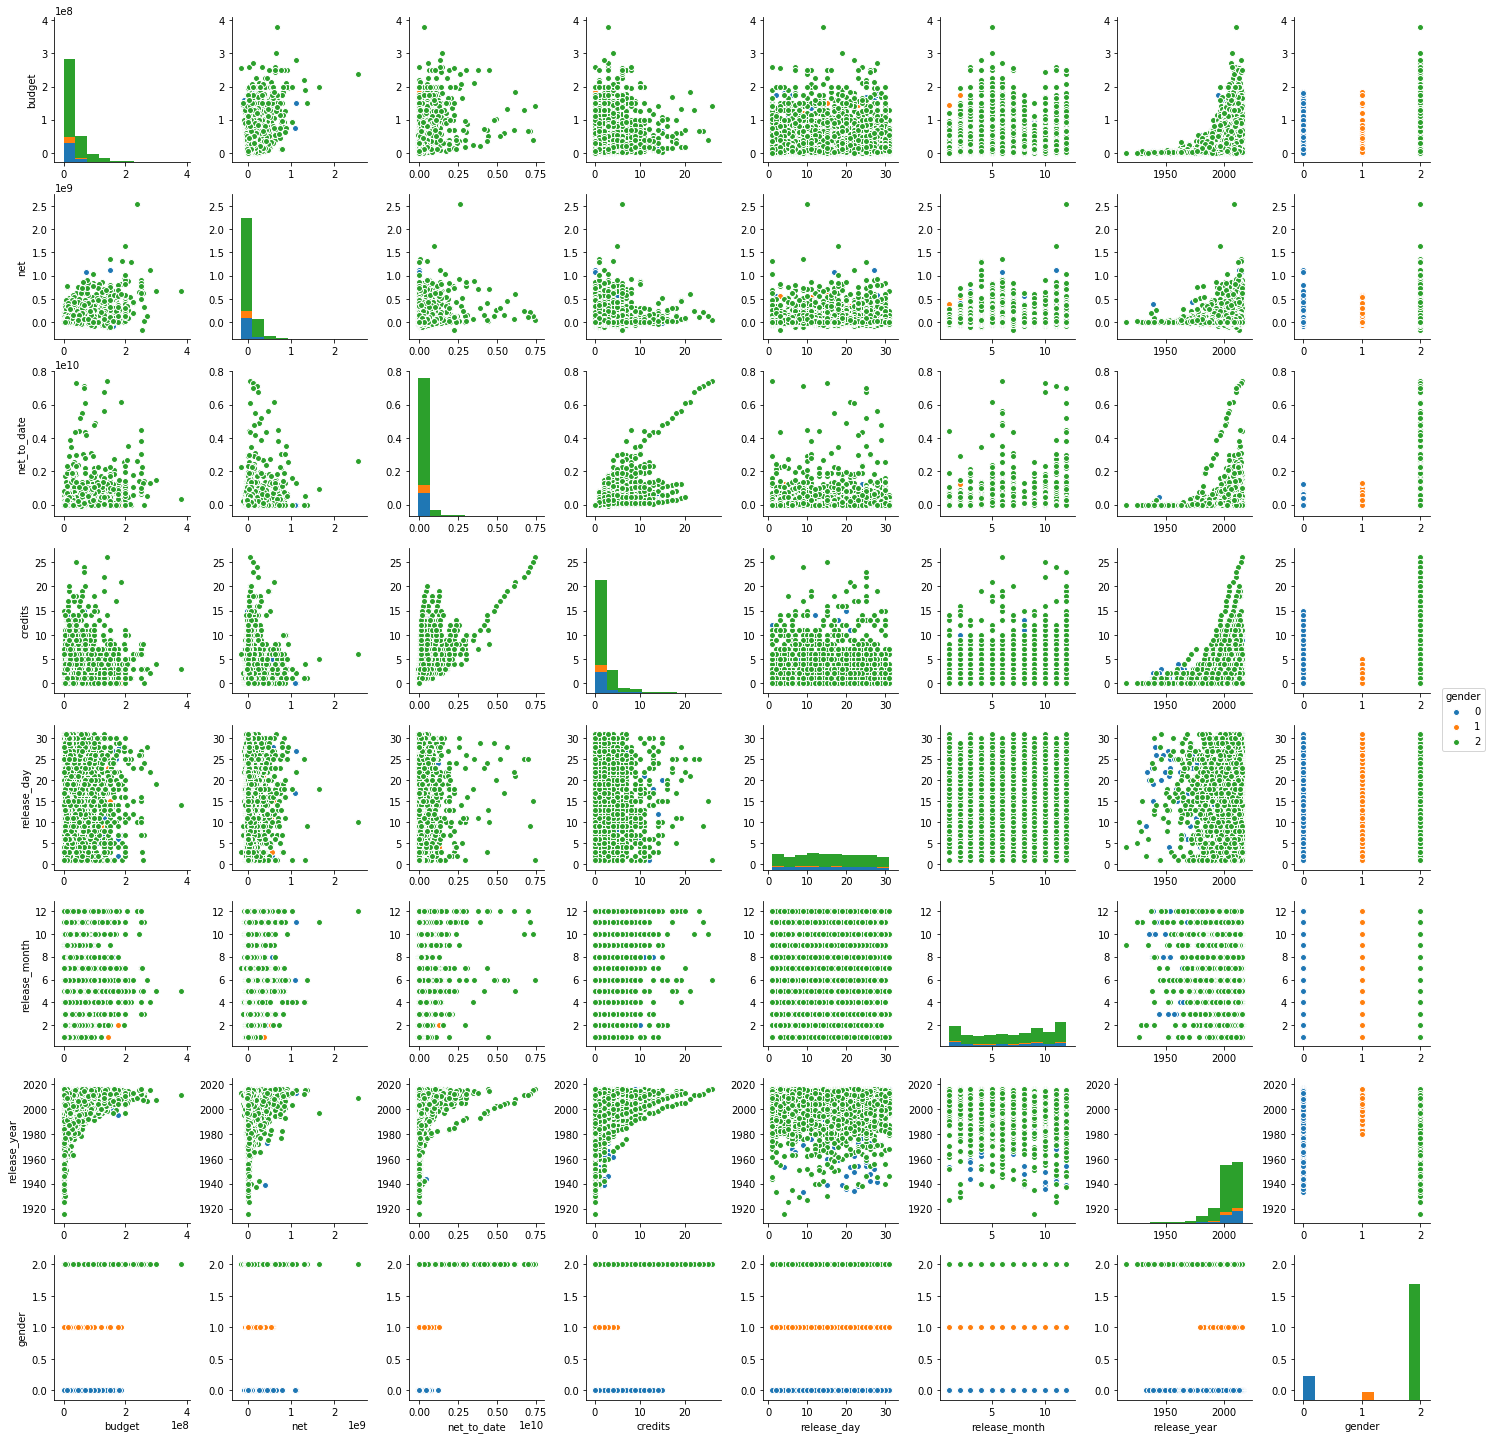

In [33]:
sns.pairplot(crew_dfs['Director'][['budget', 'net', 'net_to_date','credits', 'release_day', 'release_month', 'release_year','gender']], hue='gender')